In [4]:
import numpy as np
import pandas as pd
from scipy.stats import norm, binom, bernoulli
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf

In [5]:
N = 1000

In [6]:
SIGMA = 0.2
x = norm.rvs(size=N)
alpha , beta = np.random.rand(), np.random.rand()
alpha , beta, SIGMA 

(0.512987169252755, 0.3747842513558922, 0.2)

In [7]:
y = 3 + alpha*x + SIGMA*norm.rvs(size=N)
z = 5 + beta*y + SIGMA*norm.rvs(size=N)

In [8]:
df = pd.DataFrame({'x':x,
             'y':y,
             'z':z,})

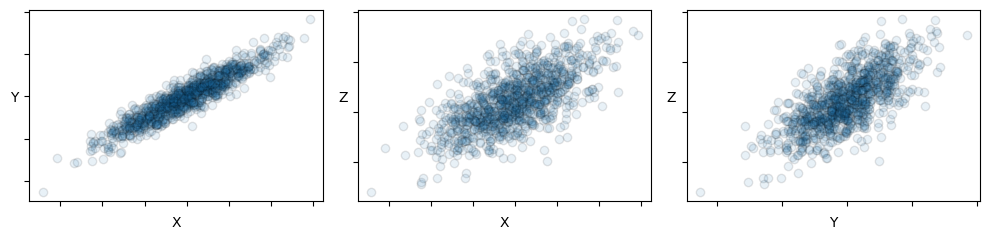

In [9]:
fig = plt.figure(figsize=(10,2.5))
#plt.suptitle("SPLS", fontsize=25)

ax = fig.add_subplot(1, 3, 1)
sns.scatterplot(x=x, y=y, alpha=0.1, linewidth=1, edgecolor='black')
ax.set_xlabel('X')
ax.set_ylabel('Y', rotation=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(1, 3, 2)
sns.scatterplot(x=x, y=z, alpha=0.1, linewidth=1, edgecolor='black')
ax.set_xlabel('X')
ax.set_ylabel('Z', rotation=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax = fig.add_subplot(1, 3, 3)
sns.scatterplot(x=y, y=z, alpha=0.1, linewidth=1, edgecolor='black')
ax.set_xlabel('Y')
ax.set_ylabel('Z', rotation=0)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.tight_layout()
plt.show()

In [11]:
df = pd.DataFrame({'x':x,
              'y':y,
              'z':z,
             })
df.head()

,x,y,z
0,1.571598,4.275320,6.830733
1,-0.023553,3.163208,6.623451
2,0.825888,3.435139,6.454574
3,1.516385,3.650804,6.592163
4,0.262398,3.059547,6.018789


In [14]:
df.to_csv('data/model_chain.csv', index=False)

In [38]:
mod = smf.ols(formula='z ~ x + y', data=df)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                      z   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     591.1
Date:                Sat, 18 Jan 2025   Prob (F-statistic):          5.15e-170
Time:                        19:04:53   Log-Likelihood:                 190.81
No. Observations:                1000   AIC:                            -375.6
Df Residuals:                     997   BIC:                            -360.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.8915      0.095     51.300      0.0

### correlation    

In [39]:
print(f'(x,y) r:{pearsonr(x,y).statistic:.4f} p:{pearsonr(x,y).pvalue:.4f}')
print(f'(x,z) r:{pearsonr(x,z).statistic:.4f} p:{pearsonr(x,z).pvalue:.4f}')
print(f'(y,z) r:{pearsonr(y,z).statistic:.4f} p:{pearsonr(y,z).pvalue:.4f}')

(x,y) r:0.8756 p:0.0000
(x,z) r:0.6413 p:0.0000
(y,z) r:0.7365 p:0.0000


In [40]:
x = np.expand_dims(x, axis=1)
y = np.expand_dims(y, axis=1)
z = np.expand_dims(z, axis=1)

In [41]:
def fisherz(    
    X,
    Y,
    condition_on = None,
    correlation_matrix = None,
    ):

    if condition_on is None:
        condition_on = np.empty((X.shape[0], 0))

    # compute the correlation matrix within the specified data
    data = np.hstack((X, Y, condition_on))
    sample_size = data.shape[0]
    if correlation_matrix is None:
        correlation_matrix = np.corrcoef(data.T)

    inv = np.linalg.pinv(correlation_matrix)
    r = -inv[0, 1] / np.sqrt(inv[0, 0] * inv[1, 1])

    # apply the Fisher Z-transformation
    Z = 0.5 * np.log((1 + r) / (1 - r))

    # compute the test statistic
    statistic = np.sqrt(sample_size - condition_on.shape[1] - 3) * abs(Z)
    p = 2 * (1 - norm.cdf(abs(statistic)))
    
    print(f'{statistic:.4f}, {p:.4f}')

In [42]:
x.shape, y.shape, z.shape

((1000, 1), (1000, 1), (1000, 1))

In [43]:
condition_on = np.empty((x.shape[0], 0))
condition_on

array([], shape=(1000, 0), dtype=float64)

In [44]:
data = np.hstack((x, z, condition_on))
print(data.shape)
sample_size = data.shape[0]
correlation_matrix = np.corrcoef(data.T)

(1000, 2)


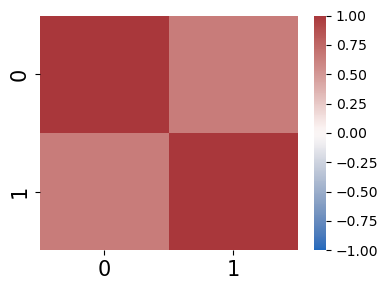

In [45]:
plt.figure(figsize=(4,3))
#plt.title('Correlation Between Variables', fontsize=25)
sns.heatmap(correlation_matrix, cmap='vlag', vmin=-1, vmax=1)
#plt.ylabel('Subjects Test', fontsize=20)
#plt.xlabel('Subjects Retest', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.show()

In [46]:
inv = np.linalg.pinv(correlation_matrix)
r = -inv[0, 1] / np.sqrt(inv[0, 0] * inv[1, 1])
r

0.6413200623584702

In [47]:
Z = 0.5 * np.log((1 + r) / (1 - r))
Z

0.7604128304454394

In [48]:
statistic = np.sqrt(sample_size - condition_on.shape[1] - 3) * abs(Z)
p = 2 * (1 - norm.cdf(abs(statistic)))

In [49]:
print(statistic)
print(p)

24.01026842182166
0.0


### X -> Y -> Z (FisherZ)

In [50]:
fisherz(x,z)
fisherz(x,z, condition_on=y)

24.0103, 0.0000
0.3406, 0.7334


In [51]:
fisherz(y,z)
fisherz(y,z, condition_on=x)

29.7688, 0.0000
16.1816, 0.0000


In [52]:
fisherz(x,y)
fisherz(x,y, condition_on=z)

42.8288, 0.0000
32.7434, 0.0000


### cov and corr

In [53]:
condition_on = np.empty((x.shape[0], 0))
data = np.hstack((x, z, condition_on))
print(data.shape)
sample_size = data.shape[0]
correlation_matrix = np.corrcoef(data.T)
correlation_matrix

(1000, 2)


array([[1.        , 0.64132006],
       [0.64132006, 1.        ]])

In [54]:
condition_on = y
data = np.hstack((x, z, condition_on))
print(data.shape)
sample_size = data.shape[0]
correlation_matrix = np.corrcoef(data.T)
correlation_matrix

(1000, 3)


array([[1.        , 0.64132006, 0.87555571],
       [0.64132006, 1.        , 0.73650025],
       [0.87555571, 0.73650025, 1.        ]])

In [55]:
inv = np.linalg.pinv(correlation_matrix)
print(inv.shape)
r = -inv[0, 1] / np.sqrt(inv[0, 0] * inv[1, 1])

(3, 3)


In [56]:
inv

array([[ 4.28494881,  0.03302848, -3.77603687],
       [ 0.03302848,  2.18572509, -1.63870536],
       [-3.77603687, -1.63870536,  5.51303755]])

In [61]:
r

-0.010792399297616304

In [67]:
np.cov(data.T)

array([[0.99061755, 0.18877142, 0.35924173],
       [0.18877142, 0.08746148, 0.08979069],
       [0.35924173, 0.08979069, 0.1699417 ]])

In [68]:
precision = np.linalg.inv(np.cov(data.T))
precision

array([[  4.3255329 ,   0.11220887,  -9.20308083],
       [  0.11220887,  24.99071758, -13.44133756],
       [ -9.20308083, -13.44133756,  32.44075767]])

In [69]:
-precision[0, 1] / np.sqrt(precision[0, 0] * precision[1, 1])

-0.010792399297616172